In [1]:
import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)
import kinodyn_um.urdfparser as u2c
import numpy as np
import casadi as ca
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.integrate import cumulative_trapezoid
from pylab import *

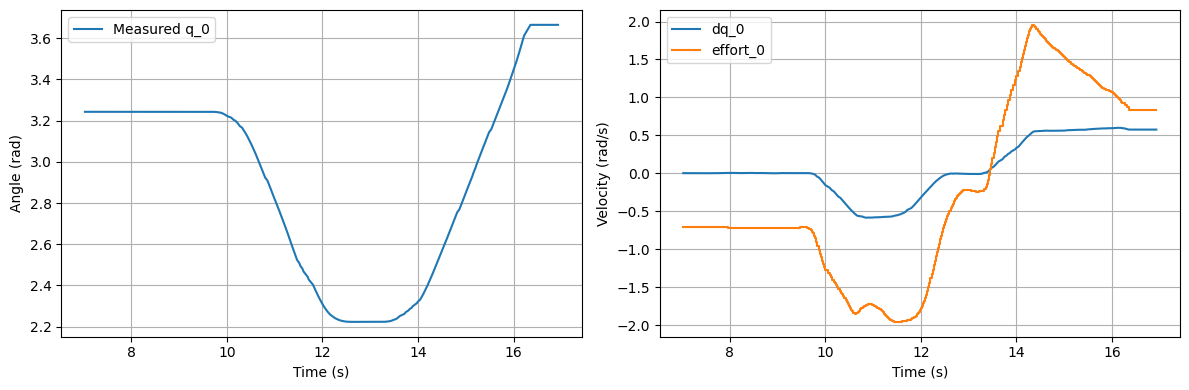

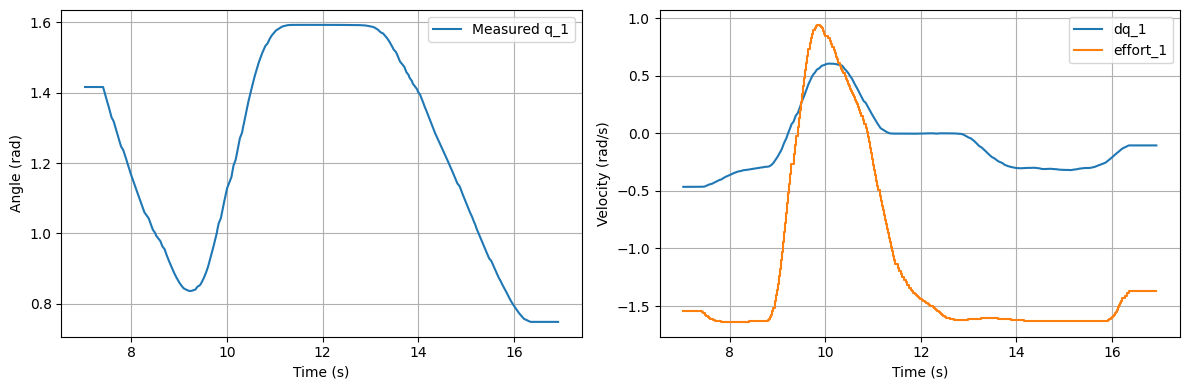

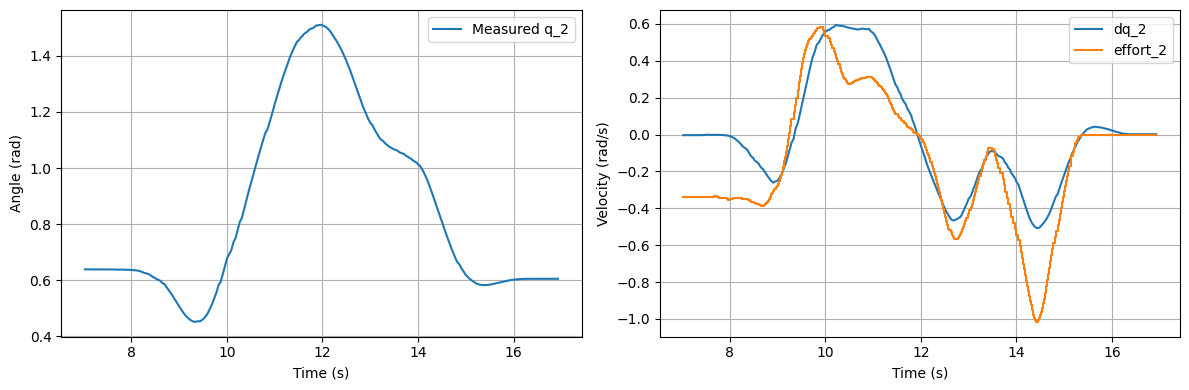

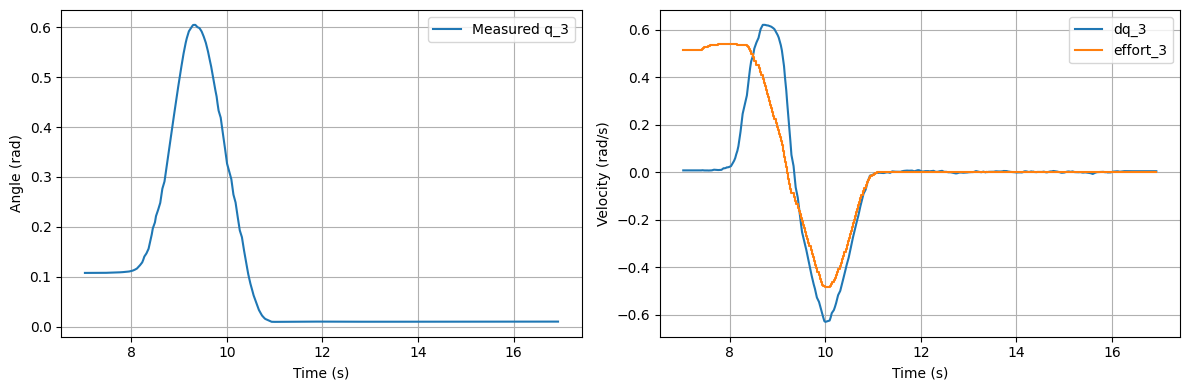

In [2]:
# Read the CSV
mass = 1.15
df = pd.read_csv(f"different_masses/{str(mass)}_mass/20250509_000349_robot_real_.csv")
df = df.assign(dt=df['timestamp'].shift(-1) - df['timestamp'])
df.loc[df.index[-1], 'dt'] = 0.0

# Remove rows where dt == 0 and reset the index
df = df[df['dt'] != 0].reset_index(drop=True)

# truncate the data to a smaller time window for visualization and system identification
df = df.iloc[300:701]

dt = df['dt']

window_length = 35  # adjust as needed based on your data length
polyorder = 0

# Smooth the IMU angular velocities using the Savitzky–Golay filter
time = df['timestamp'].values
df['q_alpha_axis_e'] = savgol_filter(df['q_alpha_axis_e'].values, window_length, polyorder)
df['q_alpha_axis_d'] = savgol_filter(df['q_alpha_axis_d'].values, window_length, polyorder)
df['q_alpha_axis_c'] = savgol_filter(df['q_alpha_axis_c'].values, window_length, polyorder)
df['q_alpha_axis_b'] = savgol_filter(df['q_alpha_axis_b'].values, window_length, polyorder)

df['dq_alpha_axis_e'] = savgol_filter(df['dq_alpha_axis_e'].values, window_length, polyorder)
df['dq_alpha_axis_d'] = savgol_filter(df['dq_alpha_axis_d'].values, window_length, polyorder)
df['dq_alpha_axis_c'] = savgol_filter(df['dq_alpha_axis_c'].values, window_length, polyorder)
df['dq_alpha_axis_b'] = savgol_filter(df['dq_alpha_axis_b'].values, window_length, polyorder)

df['effort_alpha_axis_e'] = savgol_filter(df['effort_alpha_axis_e'].values, window_length, polyorder)
df['effort_alpha_axis_d'] = savgol_filter(df['effort_alpha_axis_d'].values, window_length, polyorder)
df['effort_alpha_axis_c'] = savgol_filter(df['effort_alpha_axis_c'].values, window_length, polyorder)
df['effort_alpha_axis_b'] = savgol_filter(df['effort_alpha_axis_b'].values, window_length, polyorder)

eff_cols = [
    'effort_alpha_axis_e',
    'effort_alpha_axis_d',
    'effort_alpha_axis_c',
    'effort_alpha_axis_b'
]
# DataFrame → (T×4) → transpose → (4×T)
m_U_data = df[eff_cols].values.T

# 2) states: shape (8, T)
state_cols = [
    'q_alpha_axis_e','q_alpha_axis_d','q_alpha_axis_c','q_alpha_axis_b',
    'dq_alpha_axis_e','dq_alpha_axis_d','dq_alpha_axis_c','dq_alpha_axis_b'
]
# (T×8) → transpose → (8×T)
m_X_data = df[state_cols].values.T

# 3) dt: shape (1, N)
dt_data = df['dt'].values.reshape(1, -1)

for j in range(m_U_data.shape[0]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.plot(time, m_X_data[j, :],    label=f"Measured q_{j}")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Angle (rad)")
    ax1.legend(); ax1.grid(True)

    # velocity vs effort
    ax2.plot(time, m_X_data[j+4, :],       label=f"dq_{j}")
    plt.step(time, m_U_data[j, :], where='post',  label=f"effort_{j}")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Velocity (rad/s)")
    ax2.legend(); ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. Load robot model
# ─────────────────────────────────────────────────────────────────────────────
alpha = u2c.URDFparser()
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
path_to_urdf = os.path.join(project_root, 'usage', 'urdf', 'alpha_5_robot.urdf')
alpha.from_file(path_to_urdf)

root = "base_link"
tip  = "alpha_standard_jaws_base_link"
n_joints = alpha.get_n_joints(root, tip)

q = ca.SX.sym("q", n_joints)
q_dot = ca.SX.sym("q_dot", n_joints)
tau = ca.SX.sym("tau", n_joints)
actuator_gain   = ca.SX.sym("gain",   n_joints,2)   # joint-wise gain
actuator_bias   = ca.SX.sym("bias",   n_joints,2)   # joint-wise bias
gravity = ca.SX.sym("g")
link_gravity = ca.SX.sym("link_g")
sign_K        = ca.SX.sym("sign_K", n_joints, 2)
viscous  = ca.SX.sym("visc",   n_joints, 2)
coulomb  = ca.SX.sym("coul",   n_joints, 2)
payload_props  = ca.SX.sym("payload_props", 4) # mass, Ixx, Iyy, Izz

q_ddot_f = alpha.get_forward_dynamics_crba(root, tip)
q_ddot = q_ddot_f(q, q_dot, tau, actuator_gain, actuator_bias, link_gravity, gravity, sign_K, viscous, coulomb, payload_props)
f = ca.vertcat(q_dot, q_ddot)

# Continuous system dynamics as a CasADi Function
f = ca.Function('f', [q, q_dot, tau, actuator_gain, actuator_bias, link_gravity, gravity, sign_K, viscous, coulomb, payload_props], [f])

In [4]:
opti = ca.Opti()
nx = n_joints * 2
nu = n_joints
np = 40
N = m_U_data[:, :-1].shape[1]

# Decision variables for states
X = opti.variable(nx, N+1)
# Decision variables for parameter vector
P = opti.variable(np, N)

m_U = opti.parameter(nu, N)
m_X = opti.parameter(nx, N+1)
dt = opti.parameter(1, N)

x_initial = ca.vertcat([3.1, 0.7, 2.1, 0.0,  0, 0, 0, 0])
p_initial = ca.vertcat([1,1,1,1 ,
                        1,1,1,1 ,
                        0,0,0,0 ,
                        0,0,0,0 ,
                        1.23820451e+02, 1.23820437e+02, 1.23820199e+02, 1.23820446e+02,
                        1.23818582e+02, 1.23820445e+02, 1.23820450e+02, 1.23820451e+02,
                        
                        2.65212180e+00, 2.23801687e+00, 1.36440968e+00, 3.53203598e-01,
                        3.09552577e+00, 3.52105211e+00, 9.76417047e-01, 3.57275142e-01,
                  
                        1.71638216e-17, 7.61787573e-16, 8.95118893e-02, 2.56682942e-18,
                        1.94048838e-17, 2.00526572e-02, 1.61355205e-16, 4.18920129e-03
                  ])
link_gravity = -9.81
gravity = -9.81
payload = ca.vertcat([mass, 0, 0, 0])

degree = 3
method = 'radau'

cpts = ca.collocation_points(degree,method)
[C,D,B] = ca.collocation_coeff(cpts)

# Gap-closing shooting constraints
for k in range(N):
   # Decision variables for helper states at each collocation point
   Xc = opti.variable(nx, degree)
   Z = ca.horzcat(X[:,k],Xc)

   Pidot = (Z @ C)/dt[:,k]
   
   actuator_gain = P[0:8, k].reshape((n_joints,2))
   actuator_bias = P[8:16, k].reshape((n_joints,2))
   k_sgn = P[16:24, k].reshape((n_joints,2))
   viscous = P[24:32, k].reshape((n_joints,2))
   coulomb = P[32:40, k].reshape((n_joints,2))

   xdot = f(Xc[0:4, :], Xc[4:8, :], m_U[:, k], actuator_gain, actuator_bias, link_gravity, gravity, k_sgn, viscous, coulomb, payload)
   
   opti.subject_to(Pidot==xdot)

   # Continuity constraints
   opti.subject_to(Z @ D==X[:,k+1])
   opti.set_initial(Xc, ca.repmat(x_initial,1,degree))
           
# Path constraints
opti.subject_to(opti.bounded(1.0,ca.vec(X[0,:]),5.50))
opti.subject_to(opti.bounded(0.01,ca.vec(X[1,:]),3.40))
opti.subject_to(opti.bounded(0.01,ca.vec(X[2,:]),3.40))
opti.subject_to(opti.bounded(0.01,ca.vec(X[3,:]),5.70))

opti.subject_to(ca.vec(P[0:8, :]) >= 0.0)
opti.subject_to(ca.vec(P[24:32, :]) >= 0.0)
opti.subject_to(ca.vec(P[32:40, :]) >= 0.0)


# Initial guesses
opti.set_initial(X, ca.repmat(x_initial,1,N+1))
opti.set_initial(P, ca.repmat(p_initial,1,N))

# Initial and terminal constraints
opti.subject_to(X[:,0]==m_X[:, 0])

# Objective: 
opti.minimize(ca.sumsqr(ca.vec(X[4:8,:])-ca.vec(m_X[4:8,:])))

opts = {"print_time": 0,"expand":True,
        "ipopt": {"max_iter":2000}}



# solve optimization problem
opti.solver('ipopt', opts)

opti.set_value(m_U, m_U_data[:, :-1])
opti.set_value(m_X, m_X_data[:, :])
opti.set_value(dt, dt_data[:, :-1])

sol = opti.solve()



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   275208
Number of nonzeros in inequality constraint Jacobian.:    11204
Number of nonzeros in Lagrangian Hessian.............:   224004

Total number of variables............................:    28808
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    12808
Total number of inequality c

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:217:
.../casadi/core/optistack_internal.cpp:1336: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Maximum_Iterations_Exceeded'

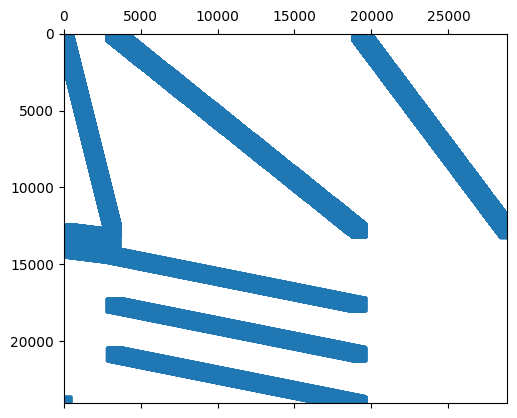

In [11]:
figure()
spy(opti.debug.value(ca.jacobian(opti.g,opti.x)))

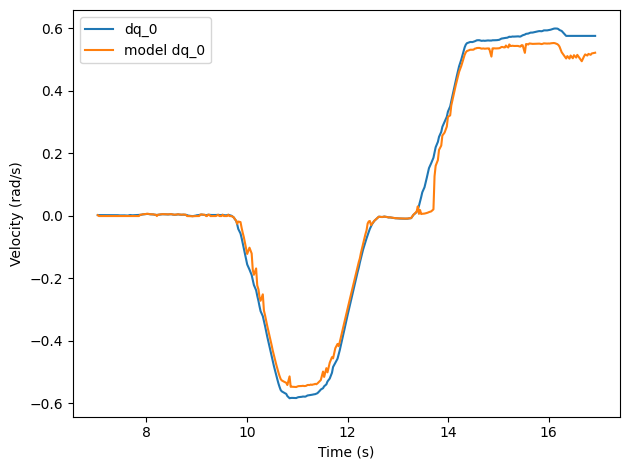

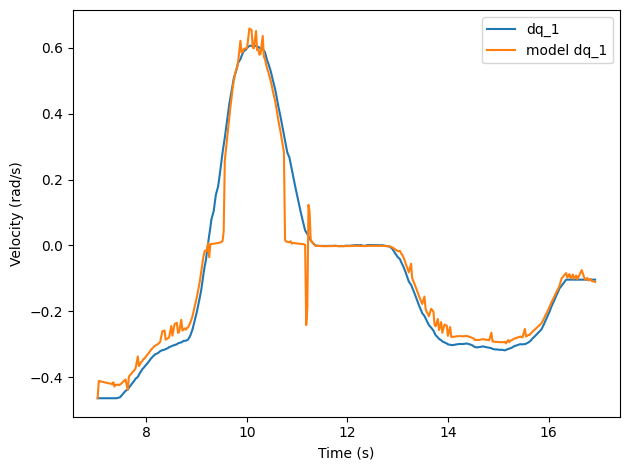

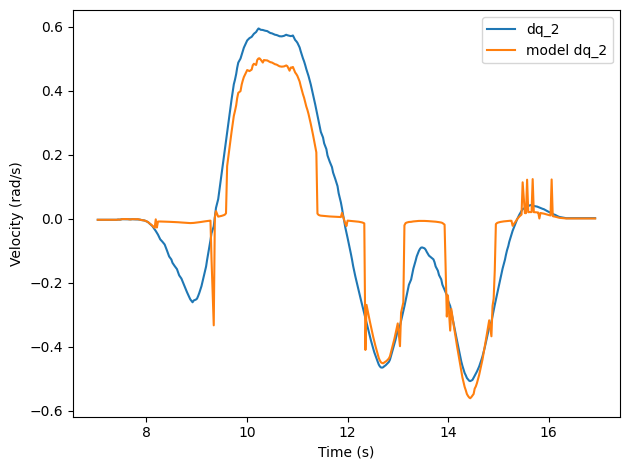

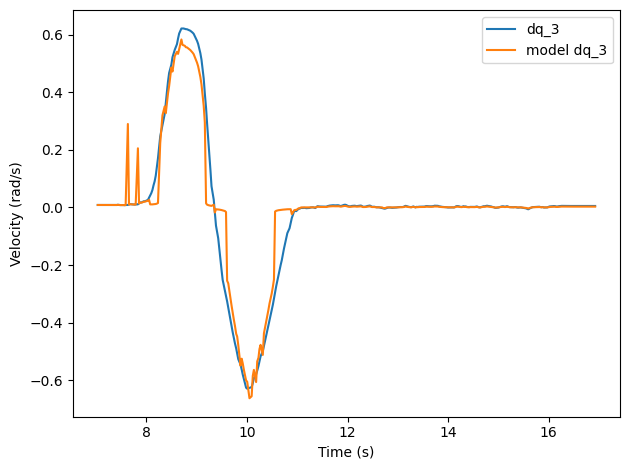

In [12]:
for j in range(m_U_data.shape[0]):
    # velocity vs effort
    plt.plot(time, m_X_data[j+4, :],       label=f"dq_{j}")
    plt.plot(time, opti.debug.value(X)[j+4, :],       label=f"model dq_{j}")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (rad/s)")
    plt.legend(); ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [9]:
opti.debug.value(P[:,0])

array([7384.83016434, 7384.83016469, 7384.83016434, 7448.06009332,
       7169.28941876, 7043.64102986, 7378.68283726, 7384.83016452,
          0.        ,    0.        ,    0.        ,   99.71013988,
       1052.09104422,  166.62735286,   15.78556587,    0.        ,
        123.820451  ,  123.820437  ,  123.820199  ,   69.93697671,
        937.41488605,  123.82044604,  114.68524056,  123.820451  ,
       7384.83873212, 7384.83615661, 7384.8316105 , 7383.68880724,
       7385.02213701, 7473.72689415, 7384.88502961, 7384.82860255,
       7384.82824235, 7384.82824235, 7384.82832857, 7319.70026635,
       7479.9560146 , 7626.11881895, 7390.85182611, 7384.8282443 ])

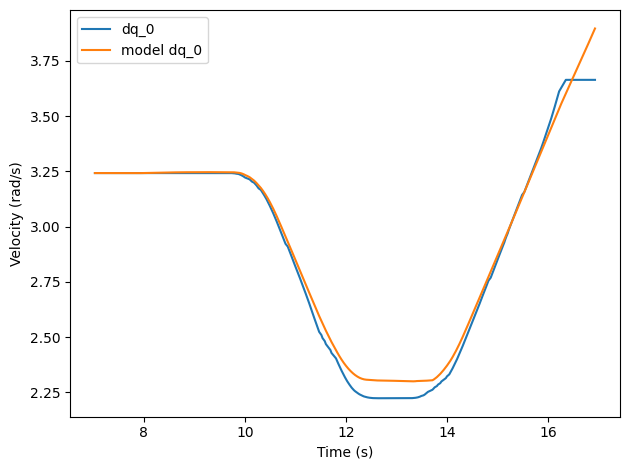

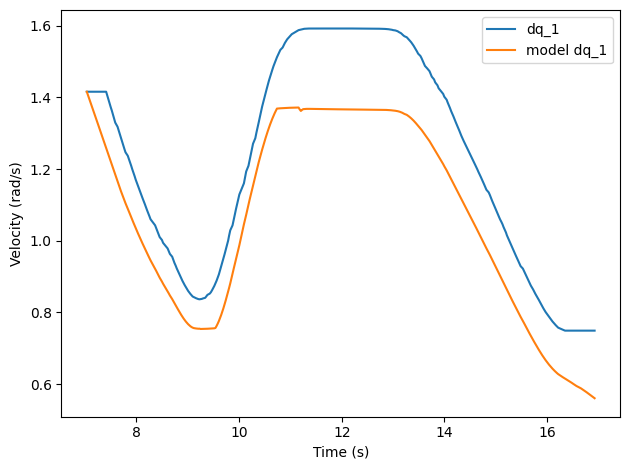

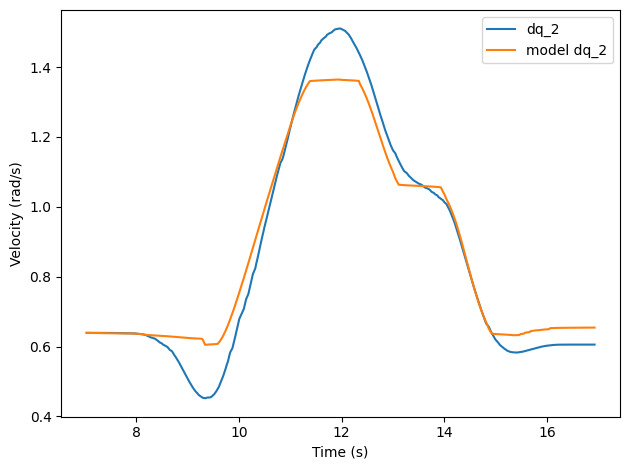

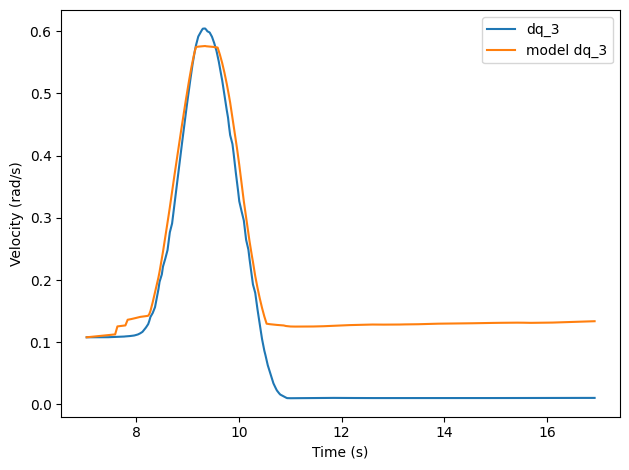

In [10]:
for j in range(m_U_data.shape[0]):
    # velocity vs effort
    plt.plot(time, m_X_data[j, :],       label=f"dq_{j}")
    plt.plot(time, opti.debug.value(X)[j, :],       label=f"model dq_{j}")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (rad/s)")
    plt.legend(); ax2.grid(True)

    plt.tight_layout()
    plt.show()